## A demo using two-qubit HeisenbergModel Hamiltonian with GPT-QE (using minGPT code).

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [10]:
from qwrapper.hamiltonian import HeisenbergModel
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.initializer import ZBasisInitializer
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer

molecule = generate_molecule("H", "H", 0.7414, "sto-3g")
nqubit = 4

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule)

# prepare operator_pool
uccsd = UCCSD(4, molecule)
paulis = uccsd.paulis
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool, [0.025, -0.025, 0.05, -0.05, 0.1, -0.1])


converged SCF energy = -1.11668438708534
Starting to parse FermionOperator using 4 qubits...

Operator t:  -0.09886396933545816 [] +
0.04532220205287399 [X0 Z1 X2] +
0.04532220205287399 [X0 Z1 X2 Z3] +
0.04532220205287399 [Y0 Z1 Y2] +
0.04532220205287399 [Y0 Z1 Y2 Z3] +
0.17119774903432977 [Z0] +
0.17119774903432972 [Z0 Z1] +
0.165867024105892 [Z0 Z1 Z2] +
0.165867024105892 [Z0 Z1 Z2 Z3] +
0.12054482205301804 [Z0 Z2] +
0.12054482205301804 [Z0 Z2 Z3] +
0.1686221915892094 [Z1] +
-0.2227859304041847 [Z1 Z2 Z3] +
0.17434844185575682 [Z1 Z3] +
-0.22278593040418473 [Z2]
Term, coeff:  () -0.09886396933545816
Term, coeff:  ((0, 'Z'),) 0.17119774903432977
Index, p_char:  0 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.17119774903432972
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.22278593040418473
Index, p_char:  2 Z
Term, coeff:  ((1, 'Z'), (2, 'Z'), (3, 'Z')) -0.2227859304041847
Index, p_char:  1 Z
Index, p_char:  2 Z
Index, p_char:  3 Z
Term, coeff:  ((1, 'Z'),) 0.1686221915

## FCI energy by diagonalization

In [11]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))

-1.137270174660903


## Setup for GPT

In [12]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 40  # The number of gates for each circuit
model_config.n_samples = 5
model_config.temperature = 20  # Each gate is generated with probability exp(-temperature * logit)
model = GPT(model_config, cost)

number of parameters: 85.16M


In [13]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 300
train_config.num_workers = 0
trainer = Trainer(train_config, model)

running on device cpu


In [14]:
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        model.temperature += 0.1


trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_hydrogen')

energies: tensor([-0.3948, -0.2306, -0.4792, -0.3686, -0.5783])
mean: tensor(-0.4103)
iter_dt 0.00ms; iter 0: train loss 0.78740
energies: tensor([-0.2674, -0.2481, -0.6670, -0.3920, -0.2911])
mean: tensor(-0.3731)
energies: tensor([-0.3467, -0.2516, -0.3950, -0.6896, -0.1724])
mean: tensor(-0.3711)
energies: tensor([-0.1358, -0.0940, -0.2746, -0.2102, -0.1941])
mean: tensor(-0.1817)
energies: tensor([-0.2798, -0.2287, -0.3323, -0.5034, -0.2044])
mean: tensor(-0.3097)
energies: tensor([-0.0936, -0.1158, -0.3341, -0.4105, -0.1572])
mean: tensor(-0.2222)
energies: tensor([-0.3695, -0.4031, -0.2078, -0.0959, -0.0641])
mean: tensor(-0.2281)
energies: tensor([-0.3250, -0.2366, -0.1692, -0.2237, -0.4378])
mean: tensor(-0.2785)
energies: tensor([-0.3093, -0.3376, -0.3186, -0.1244, -0.1486])
mean: tensor(-0.2477)
energies: tensor([-0.2327, -0.3142, -0.3816, -0.2101, -0.3143])
mean: tensor(-0.2906)
energies: tensor([-0.2762, -0.4171, -0.3904, -0.3416, -0.3030])
mean: tensor(-0.3457)
iter_dt 763

In [15]:
model.load_state_dict(torch.load('../saved_models/gptqe_hydrogen'))

<All keys matched successfully>

tensor([51, 25, 25, 32, 25,  2, 51, 51, 51,  2,  2, 51, 18, 28, 25, 51, 28, 25,
        47, 25, 51, 18, 25, 18,  2, 28, 25, 25,  2, 51, 25, 51, 25, 25,  2, 25,
         2,  2, 28, 51])


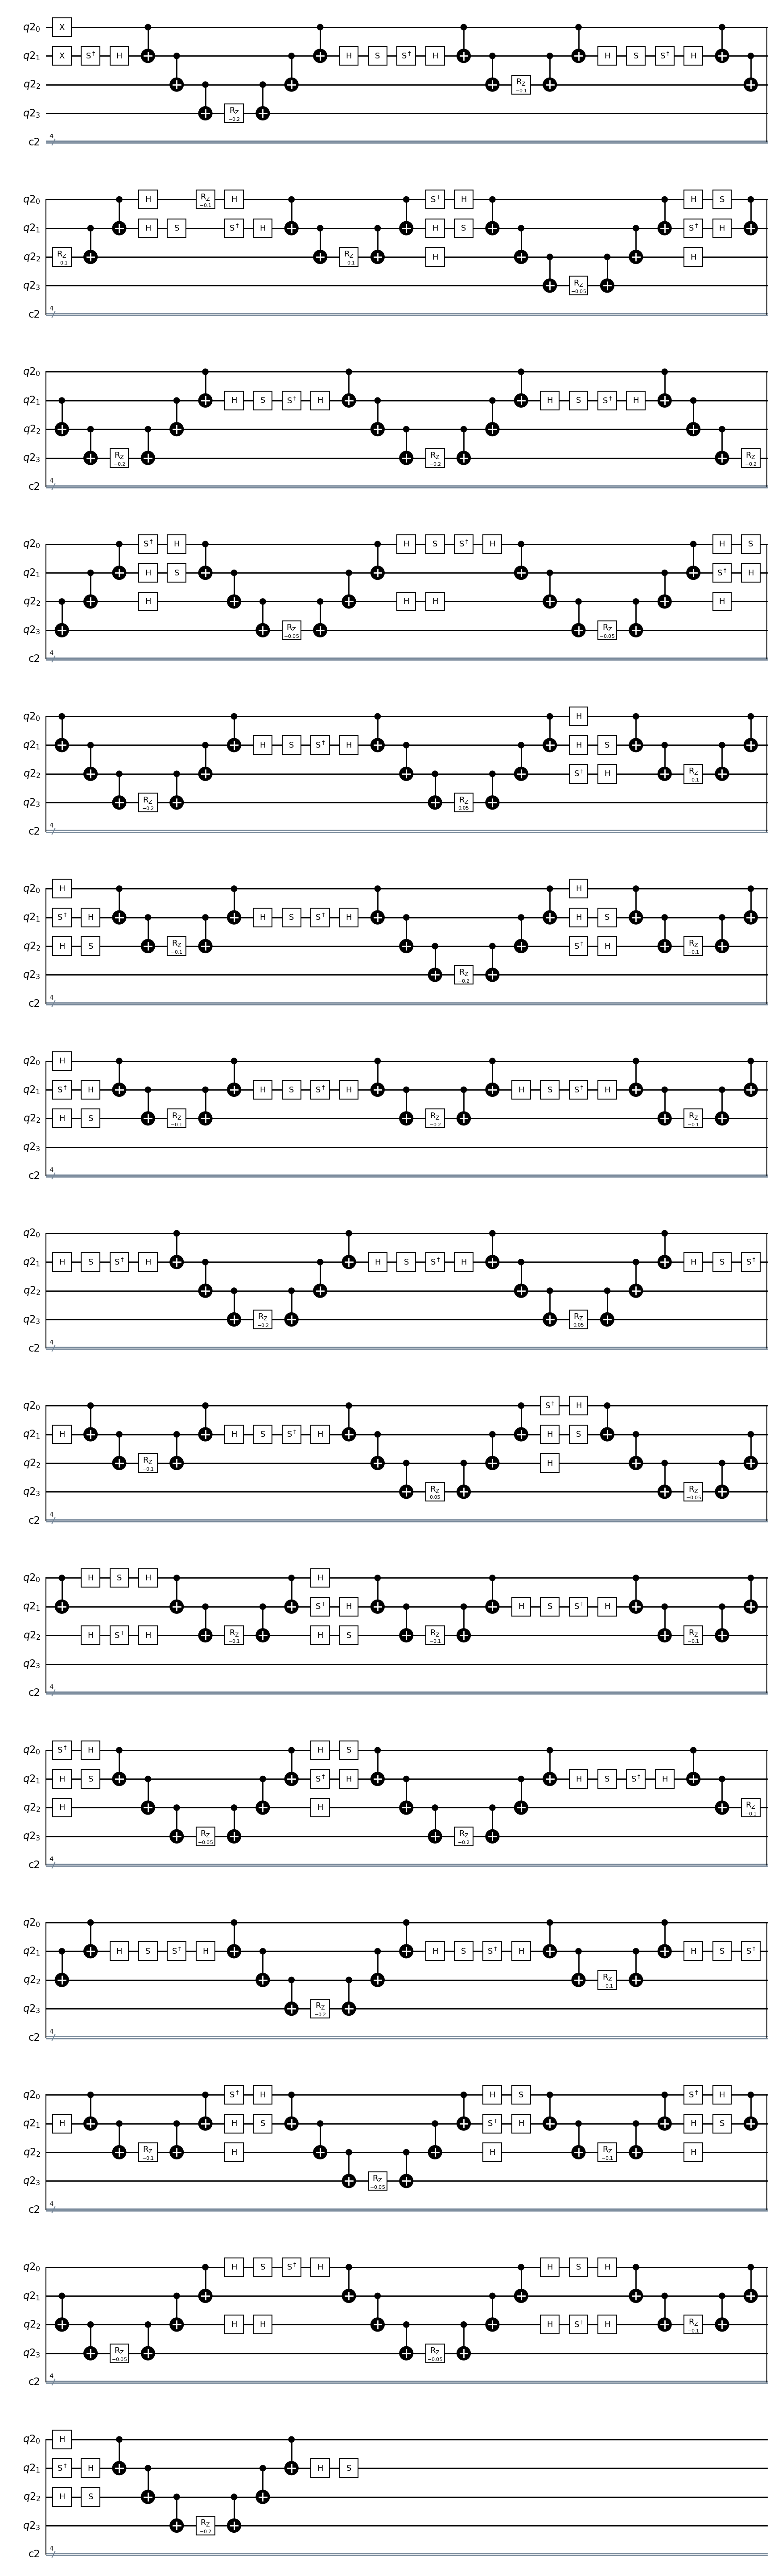

In [17]:
indices, logits = model.generate(torch.tensor([[0]]), 40)
cost.sequence.tool = "qiskit"
print(indices[0][1:])
cost.sequence._get_circuit(indices[0][1:].numpy()).draw()